In [1]:
from __future__ import division

import warnings
warnings.filterwarnings('always', append=True)

import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

In [2]:
import helpy
import helplt
import melting as melt

modules = [helpy, helplt, melt]

In [3]:
rcs = helplt.rcParam_diff('PREPYLAB')

                  KEY:     DEFAULT      =>     PREPYLAB    
           figure.dpi:      100.0       =>       72.0      
     figure.edgecolor:        w         =>   (1, 1, 1, 0)  
     figure.facecolor:        w         =>   (1, 1, 1, 0)  
       figure.figsize:    [6.4, 4.8]    =>    [6.0, 4.0]   
figure.subplot.bottom:       0.11       =>      0.125      
          text.usetex:        0         =>       ...       


In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
rcs = helplt.rcParam_diff('POSTPYLAB', rcs)

                  KEY:     DEFAULT      =>     PREPYLAB     =>    POSTPYLAB    
           figure.dpi:      100.0       =>       72.0       =>       ...       
     figure.edgecolor:        w         =>   (1, 1, 1, 0)   =>       ...       
     figure.facecolor:        w         =>   (1, 1, 1, 0)   =>       ...       
       figure.figsize:    [6.4, 4.8]    =>    [6.0, 4.0]    =>       ...       
figure.subplot.bottom:       0.11       =>      0.125       =>       ...       
          interactive:        0         =>       ...        =>        1        
          text.usetex:        0         =>       ...        =>       ...       


In [6]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [8]:
reloaded = [str(m) for m in map(reload, modules) if m.__file__.endswith('.py')]
if reloaded:
    print '\n\t'.join(['reloaded:'] + reloaded)
    print

mess, commit = helpy.getcommit(True)
print mess, str(commit.authored_datetime)[:-9], commit.summary
assert commit.repo.active_branch.name in ('melt')

 6b954c3(melt+) 2017-08-02 18:43 Allow even-numbered shells


In [9]:
prefix_fmt = '{particle}/{W}x_{config}/{W}x_{config}_{run}'

In [10]:
dataset_args = {
    'particle': 'diag',
    'W':        12,
    'config':   'in',
    'run':      1,
}

nshells = (dataset_args['W']+1)//2
maxshell = dataset_args['W']//2

prefix = prefix_fmt.format(**dataset_args)
print prefix

diag/12x_in/12x_in_1


In [11]:
def make_plot_args(meta):
    maxshell = meta['crystal_width']//2
    return {
    'line_props': helpy.transpose_dict_of_lists({
        'label': ['center', 'inner'] + range(2, maxshell) + ['outer', 'all'],
        'c':    map(plt.get_cmap('Dark2'), xrange(maxshell+1)) + ['black'],
        'lw':   [1]*(maxshell+1) + [2],
    }),
    'xylabel': {
        'f':    r'$t \, f$',
        'rad':  r'radial distance $r - \langle r \rangle$',
        'dens': r'density $\langle r_{ij}\rangle^{-2}$',
        'psi':  r'bond angle order $\Psi$',
        'phi':  r'molecular angle order $\Phi$',
    },
    'xylim': {
        'f':    (-25, (meta['end_frame'] - meta['start_frame'])/meta['fps']),
        'rad':  (0, None),
        'dens': (0, 1.1),
        'phi':  (0, 1.1),
        'psi':  (0, 1.1),
    },
    'unit': {
        'f':    1/meta['fps'],
        'rad':  1/meta['sidelength'],
        'dens': meta['sidelength']**2,
        'phi':  1,
        'psi':  1,
        'sh':   1,
    },
    'norm': {
        'f':    None,
        'rad':  [0, 75],
        'dens': (0, 1),
        'phi':  (0, 1),
        'psi':  (0, 1),
        'sh':   None,
    },
    }

In [23]:
def load_melting_stuff(particle, W, config, run):
    prefix_fmt = '/Users/leewalsh/Squares/melting/analysis/{particle}/{W}x_{config}/{W}x_{config}_{run}'
    prefix = prefix_fmt.format(particle=particle, W=W, config=config, run=run)

    meta = helpy.load_meta(prefix)
    data = helpy.load_data(prefix)
    tsets = helpy.load_tracksets(
        data, run_repair='interp', run_track_orient=True)
    # to get the benefits of tracksets (interpolation, stub filtering):
    data = np.concatenate(tsets.values())
    data.sort(order=['f', 't'])

    mdata = np.load(prefix + '_MELT.npz')['data']

    frames, mframes = helpy.load_framesets((data, mdata), ret_dict=False)
    nshells = (W+1)//2
    maxshell = W//2
    plot_args = make_plot_args(meta)
    end_index = np.searchsorted(mdata['f'], meta['end_frame'])
    shells = melt.split_shells(mdata[:end_index], zero_to=1, do_mean=True, maxshell=maxshell)
    shell_means = melt.average_shells(shells, stats, 'f')
    return prefix, meta, data, mdata, frames, mframes, shells, shell_means, plot_args

# Shells vs. Time

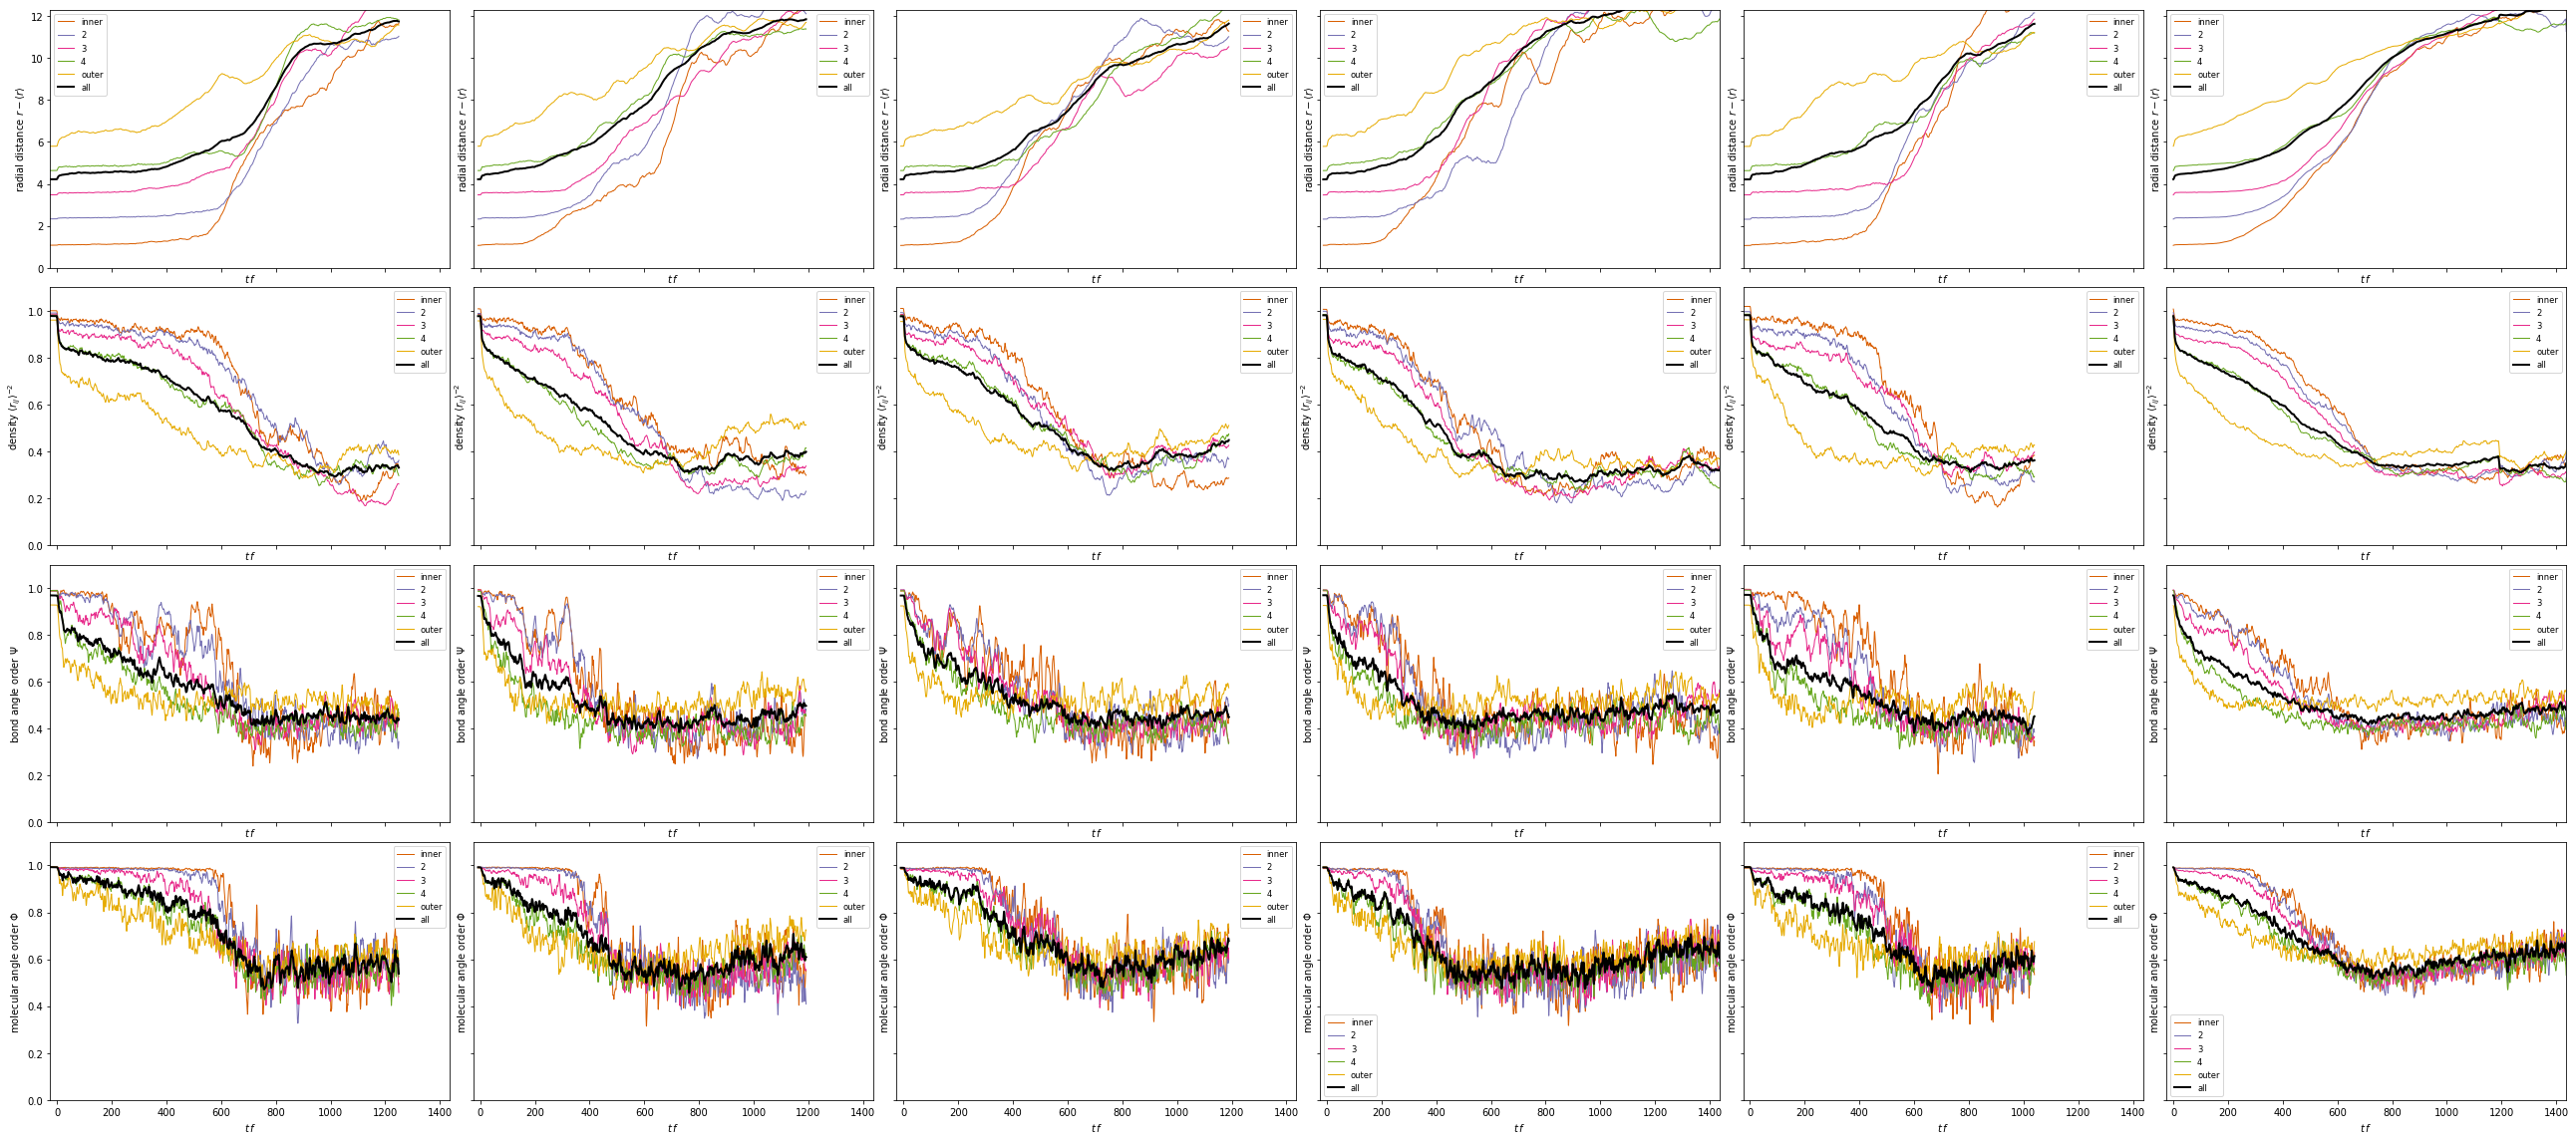

In [38]:
save = False

particle = 'pdms'
W = 11
config = 'in'
runs = range(1, 6) + ['MRG']

stats = ['rad', 'dens', 'psi', 'phi']

ncols, nrows = len(runs), len(stats)
figsize = np.array(plt.rcParams['figure.figsize'])
figsize *= [ncols, nrows]
fig, axeses = plt.subplots(figsize=figsize,
                           ncols=ncols, nrows=nrows,
                           sharex='all', sharey='row')

for run, axes in zip(runs, axeses.T):
    loaded = load_melting_stuff(particle, W, config, run)
    prefix, meta, data, mdata, frames, mframes, shells, shell_means, plot_args = loaded

    for stat, ax in zip(stats, axes):
        ax = melt.plot_by_shell(
            shell_means, 'f', stat,
            start=meta['start_frame'],
            smooth=meta['fps'],
            ax=ax, **plot_args)

    fig.tight_layout(h_pad=0, w_pad=0)

    if save:
        save_name_pattern = '{prefix}_{stat}.pdf'
        save_name = save_name_pattern.format(prefix=prefix, stat='OPs_by_shell_vs_time')
        fig.savefig(save_name, bbox_inches='tight', pad_inches=0)